## 2. Feature Selection & Transformations

In [143]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import StrMethodFormatter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn import model_selection
import re
from boruta import BorutaPy
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pickle
from mpl_toolkits.mplot3d import Axes3D
from bioinfokit.visuz import cluster
import warnings
warnings.filterwarnings('ignore')

In [59]:
df = pd.read_csv('data/1_eda.csv')

### 2.1. Feature Importance Using Random Forest

Training done using Random Forest


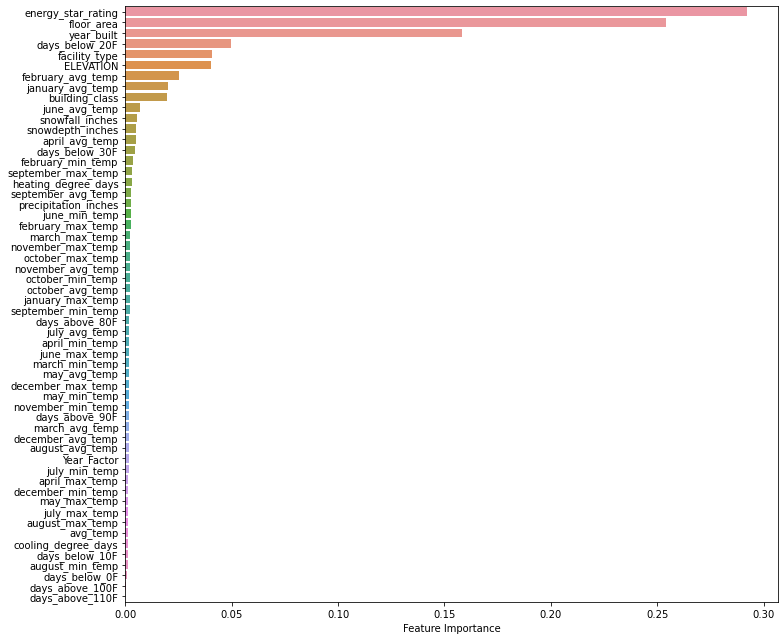

In [105]:
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(df.iloc[:,:-1], df['site_eui'])
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=df.iloc[:,:-1].columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### 2.2. Feature Engineering

In [60]:
df['SpringTemp'] = (df.march_avg_temp + df.april_avg_temp + df.may_avg_temp)/3
df['SummerTemp'] = (df.june_avg_temp + df.july_avg_temp + df.august_avg_temp)/3
df['FallTemp'] = (df.september_avg_temp + df.october_avg_temp + df.november_avg_temp)/3
df['WinterTemp'] = (df.december_avg_temp + df.january_avg_temp + df.february_avg_temp)/3

# Interaction Terms
df['floorxBuilt'] = df.floor_area * df.year_built 
df['floorxEnergy'] = df.floor_area * df.energy_star_rating
df['floorxBuiltxEnergy'] = df.floor_area * df.year_built * df.energy_star_rating
df['floorxHeatCool'] = df.floor_area *(df.cooling_degree_days + df.heating_degree_days)

df["freezing_days"] = df.days_below_0F + df.days_below_10F
df["cold_days"] = df.days_below_20F + df.days_below_30F
df["warm_days"] = df.days_above_80F + df.days_above_90F
df["hot_days"] = df.days_above_100F + df.days_above_110F
    
df["floor_areaxenergy_star_rating"] = df.floor_area*df.energy_star_rating

# Interaction Term
df["floor_areaxELEVATION"] = df.floor_area*df.ELEVATION

df["snow_rain_inches"] = df.snowfall_inches + df.precipitation_inches

In [61]:
## Removing temperature related redundant features used above
## Building Characteristic features to be investigated further 
df = df.drop(['days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F','precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'january_avg_temp', 
         'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days'],1)

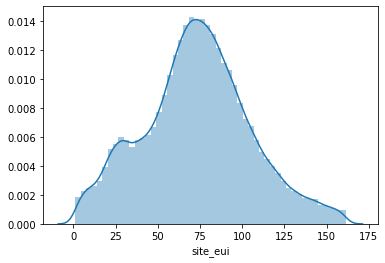

In [62]:
## No skewness therefore no need for transformations on the response variable
ax = sns.distplot(df['site_eui'])
plt.show()

In [63]:
df.columns

Index(['Year_Factor', 'building_class', 'facility_type', 'floor_area',
       'year_built', 'energy_star_rating', 'ELEVATION', 'avg_temp', 'site_eui',
       'SpringTemp', 'SummerTemp', 'FallTemp', 'WinterTemp', 'floorxBuilt',
       'floorxEnergy', 'floorxBuiltxEnergy', 'floorxHeatCool', 'freezing_days',
       'cold_days', 'warm_days', 'hot_days', 'floor_areaxenergy_star_rating',
       'floor_areaxELEVATION', 'snow_rain_inches'],
      dtype='object')

In [64]:
df_t = df.copy()

### 2.3.Feature Transformations
Looking at individual columns in order to investigate the feature distributions and skewness (if present) in depth

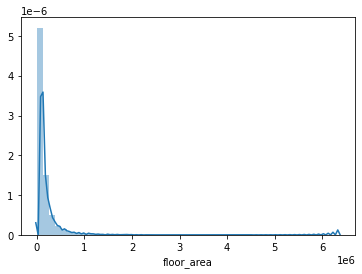

In [65]:
sns.distplot(df_t.drop('site_eui',1).floor_area)

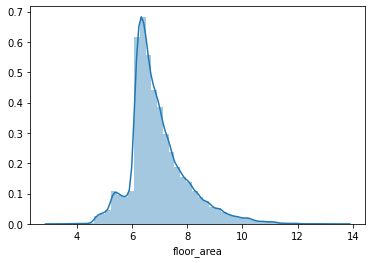

In [66]:
## Distribution right skewed therefore Inverse Power/Root Transform performed
df_t.floor_area = (df_t.floor_area)**(1/6)
sns.distplot(df_t.floor_area)

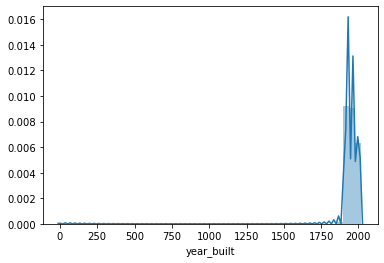

In [67]:
sns.distplot(df_t.year_built)

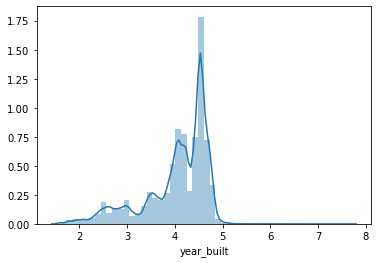

In [68]:
## Distribution left skewed therefore a log transform is performed
## 2020 (roughly max value) subtracted from the year_built inside the log transform to center the distribution
df_t.year_built = np.log(2020-df_t.year_built)
sns.distplot(df_t.year_built)

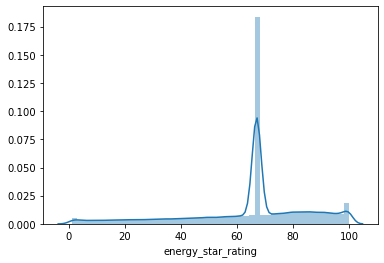

In [69]:
sns.distplot(df_t.energy_star_rating)

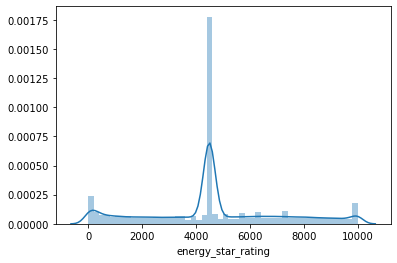

In [70]:
## Distribution left skewed therefore Square Transform performed to center the distribution
df_t.energy_star_rating = (df_t.energy_star_rating)**2
sns.distplot(df_t.energy_star_rating)

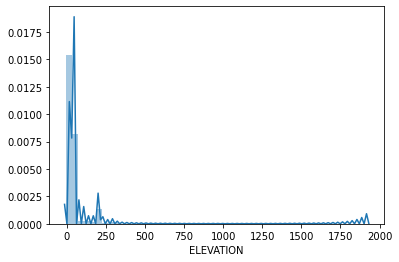

In [71]:
sns.distplot(df_t.ELEVATION)

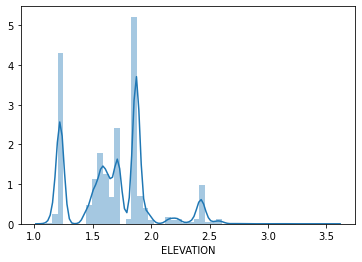

In [72]:
## Distribution right skewed therefore Inverse Power/Root Transform performed
df_t.ELEVATION = (df_t.ELEVATION)**(1/6)
sns.distplot(df_t.ELEVATION)

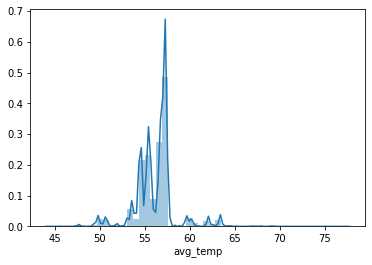

In [73]:
sns.distplot(df_t.avg_temp)

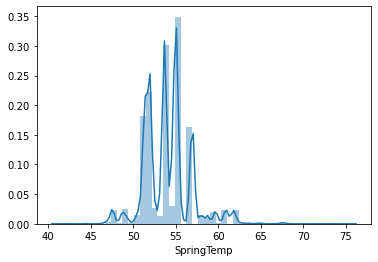

In [74]:
sns.distplot(df_t.SpringTemp)

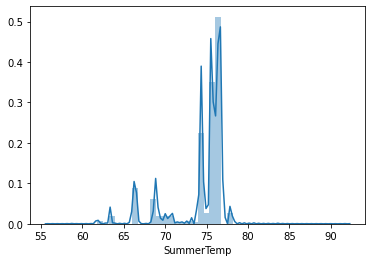

In [75]:
sns.distplot(df_t.SummerTemp)

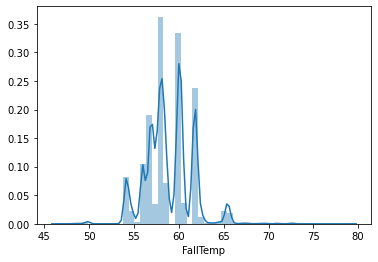

In [76]:
sns.distplot(df_t.FallTemp)

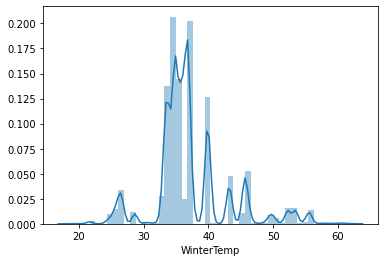

In [77]:
sns.distplot(df_t.WinterTemp)

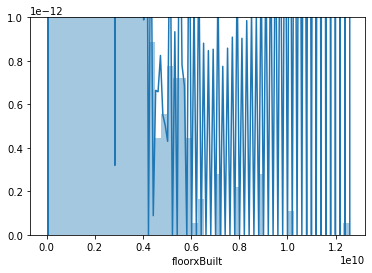

In [78]:
sns.distplot(df_t.floorxBuilt)

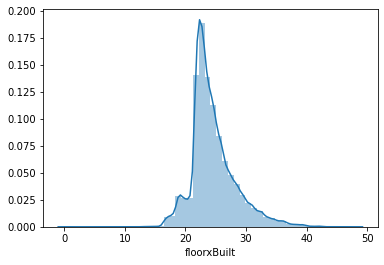

In [79]:
## Noisy Distribution therefore Inverse Power/Root Transform performed to achieve the desired result
df_t.floorxBuilt = (df_t.floorxBuilt)**(1/6)
sns.distplot(df_t.floorxBuilt)

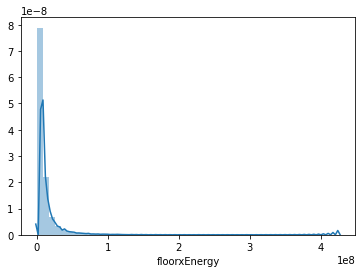

In [80]:
sns.distplot(df_t.floorxEnergy)

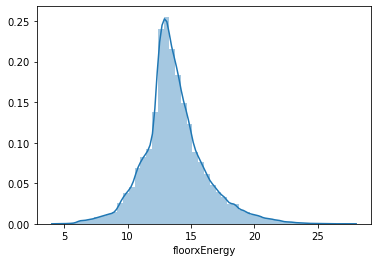

In [81]:
## Distribution left skewed therefore Inverse Power/Root Transform performed
df_t.floorxEnergy = (df_t.floorxEnergy)**(1/6)
sns.distplot(df_t.floorxEnergy)

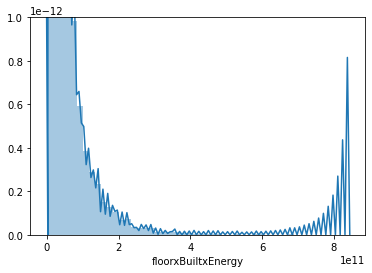

In [82]:
sns.distplot(df_t.floorxBuiltxEnergy)

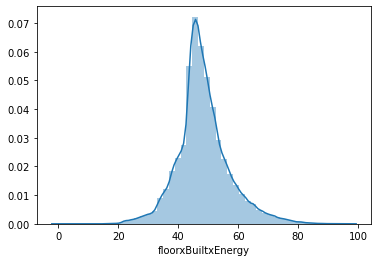

In [83]:
## Non-normal Distribution therefore Inverse Power/Root Transform performed to achieve the desired result
df_t.floorxBuiltxEnergy = (df_t.floorxBuiltxEnergy)**(1/6)
sns.distplot(df_t.floorxBuiltxEnergy)

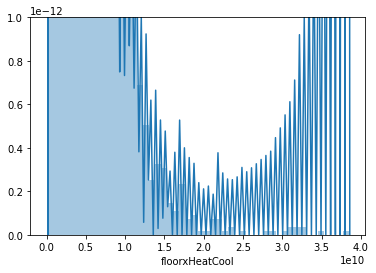

In [84]:
sns.distplot(df_t.floorxHeatCool)

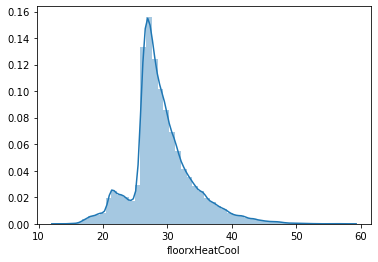

In [85]:
## Non-normal distribution therefore Inverse Power/Root Transform performed
df_t.floorxHeatCool = df_t.floorxHeatCool**(1/6)
sns.distplot(df_t.floorxHeatCool)

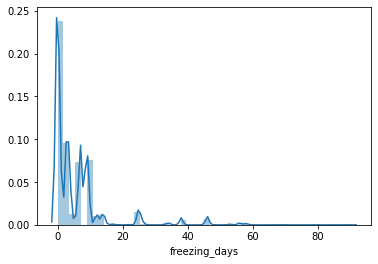

In [86]:
sns.distplot(df_t.freezing_days)

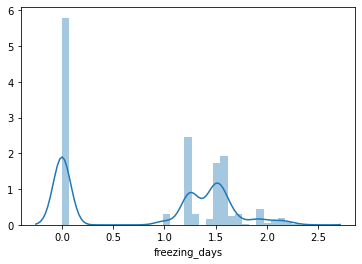

In [87]:
## Distribution right skewed therefore Inverse Power/Root Transform performed
df_t.freezing_days = (df_t.freezing_days)**(1/5)
sns.distplot(df_t.freezing_days)

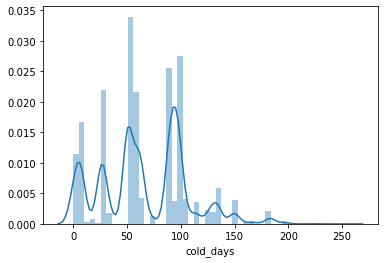

In [88]:
sns.distplot(df_t.cold_days)

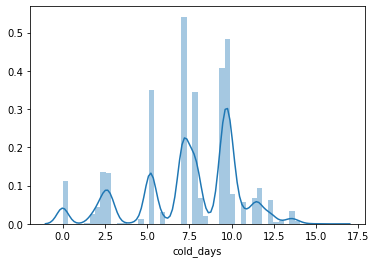

In [89]:
## Distribution slightly right skewed therefore Square Root Transform performed
df_t.cold_days = df_t.cold_days**(1/2)
sns.distplot(df_t.cold_days)

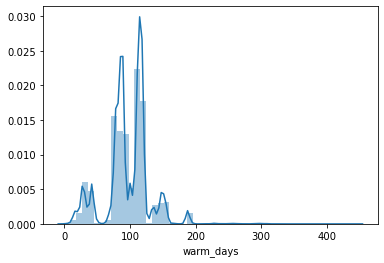

In [90]:
sns.distplot(df_t.warm_days)

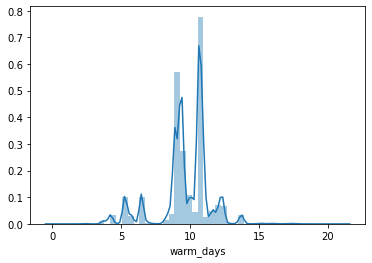

In [91]:
## Distribution slightly right skewed therefore Square Root Transform performed
df_t.warm_days = df_t.warm_days**(1/2)
sns.distplot(df_t.warm_days)

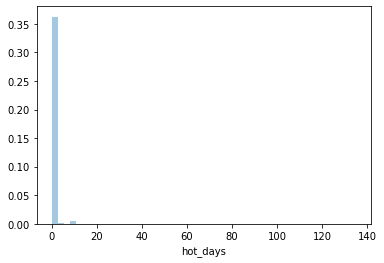

In [92]:
sns.distplot(df_t.hot_days)

In [93]:
## Majority of the values present in column hot_days are 0, therefore dropping the column
df_t = df_t.drop('hot_days',1)

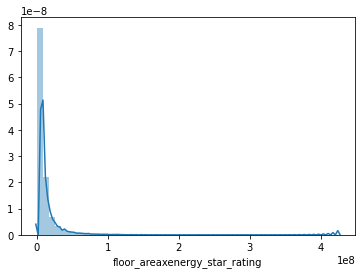

In [94]:
sns.distplot(df_t.floor_areaxenergy_star_rating)

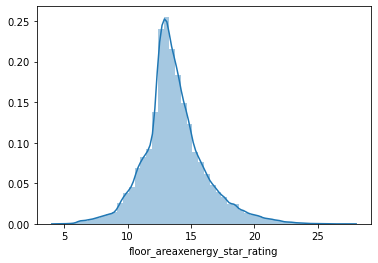

In [95]:
## Distribution right skewed therefore Inverse Power/Root Transform performed
df_t.floor_areaxenergy_star_rating = df_t.floor_areaxenergy_star_rating**(1/6)
sns.distplot(df_t.floor_areaxenergy_star_rating)

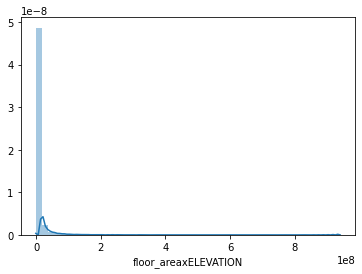

In [96]:
sns.distplot(df_t.floor_areaxELEVATION)

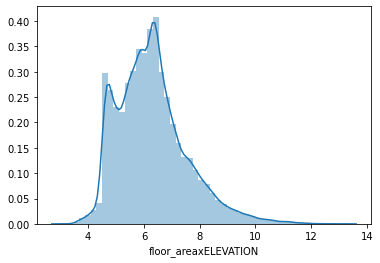

In [97]:
## Distribution right skewed therefore Inverse Power/Root Transform performed
df_t.floor_areaxELEVATION = df_t.floor_areaxELEVATION**(1/8)
sns.distplot(df_t.floor_areaxELEVATION)

In [98]:
## Performing median imputations on NA values created due to the above log transformations
df_t = df_t.fillna(df_t.median())

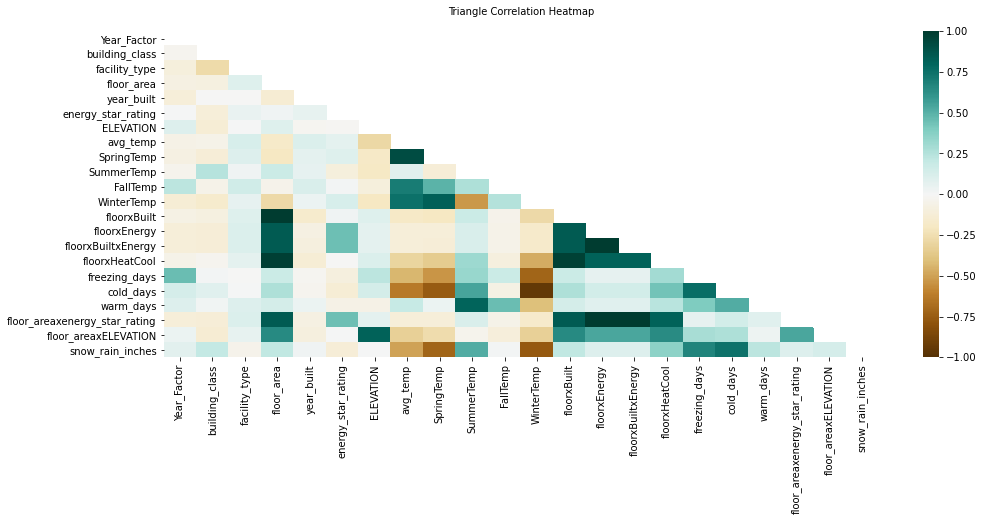

In [99]:
## Checking the correlations again after feature engineering
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_t.drop('site_eui',1).corr(), dtype=np.bool))
heatmap = sns.heatmap(df_t.drop('site_eui',1).corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [100]:
## Dropping some highly correlated features from the matrix above
df_t = df_t.drop(['floorxBuilt','floorxBuiltxEnergy','floorxHeatCool','floorxEnergy', 'ELEVATION'],1)

In [49]:
## Performing Feature Selection using Boruta package after Feature Engineering
## Boruta: https://pypi.org/project/Boruta/

forest = RandomForestRegressor(max_depth = 5)
forest.fit(df_t.drop('site_eui',1).values, df_t['site_eui'].values)

## define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

## find all relevant features
feat_selector.fit(df_t.drop('site_eui',1).values, df_t['site_eui'].values)

## check selected features
feat_selector.support_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	5
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	5
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	5
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	5
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	4
I

array([False,  True,  True,  True,  True,  True, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True])

In [50]:
## checking the ranking of features
feat_selector.ranking_

array([6, 1, 1, 1, 1, 1, 5, 4, 2, 3, 1, 7, 1, 1, 1, 1, 1])

In [102]:
## selecting all the important features from the above method
selected = df_t.drop('site_eui',1).columns[np.array(feat_selector.support_)]
selected

Index(['building_class', 'facility_type', 'floor_area', 'year_built',
       'energy_star_rating', 'WinterTemp', 'cold_days', 'warm_days',
       'floor_areaxenergy_star_rating', 'floor_areaxELEVATION',
       'snow_rain_inches'],
      dtype='object')

In [101]:
feature_ranks = list(zip(df_t.drop('site_eui',1).columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Year_Factor               Rank: 6,  Keep: False
Feature: building_class            Rank: 1,  Keep: True
Feature: facility_type             Rank: 1,  Keep: True
Feature: floor_area                Rank: 1,  Keep: True
Feature: year_built                Rank: 1,  Keep: True
Feature: energy_star_rating        Rank: 1,  Keep: True
Feature: avg_temp                  Rank: 5,  Keep: False
Feature: SpringTemp                Rank: 4,  Keep: False
Feature: SummerTemp                Rank: 2,  Keep: False
Feature: FallTemp                  Rank: 3,  Keep: False
Feature: WinterTemp                Rank: 1,  Keep: True
Feature: freezing_days             Rank: 7,  Keep: False
Feature: cold_days                 Rank: 1,  Keep: True
Feature: warm_days                 Rank: 1,  Keep: True
Feature: floor_areaxenergy_star_rating Rank: 1,  Keep: True
Feature: floor_areaxELEVATION      Rank: 1,  Keep: True
Feature: snow_rain_inches          Rank: 1,  Keep: True


In [103]:
## selecting all the important features from the above method
df_selected = df_t.drop('site_eui',1).loc[:,selected]

In [125]:
## Performed Min Max Scaling because PCA is solved via SVD and SVD approximates in the sum of squares sense
## so if one variable is on a different scale than another, it will dominate the PCA procedure.

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(df_selected)

## Aim to achieve 95% variance from PCA
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

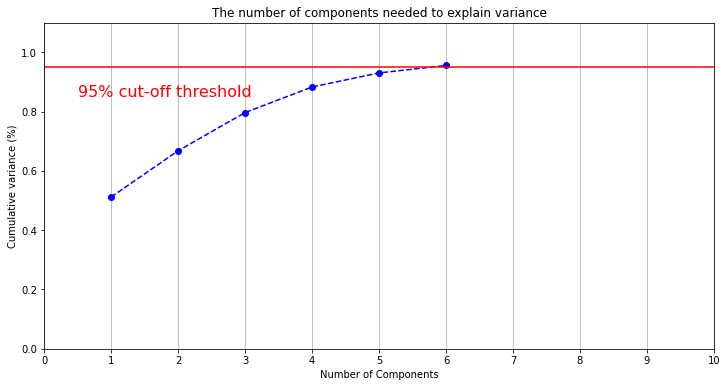

In [126]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 7, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

[0.51198152 0.15581439 0.12897644 0.08608862 0.0476304  0.02502154]


Text(0, 0.5, 'Cumulative explained variance')

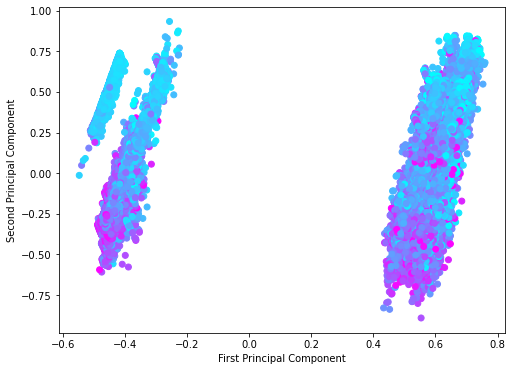

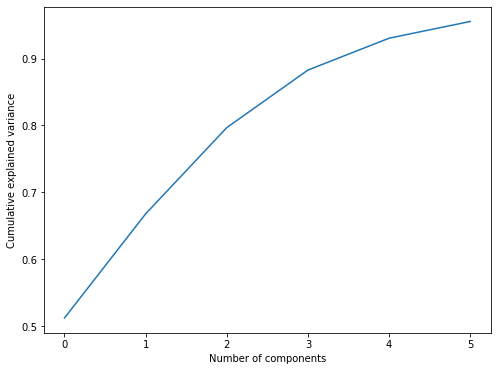

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0],reduced[:,1], c=df_t['site_eui'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

print(pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

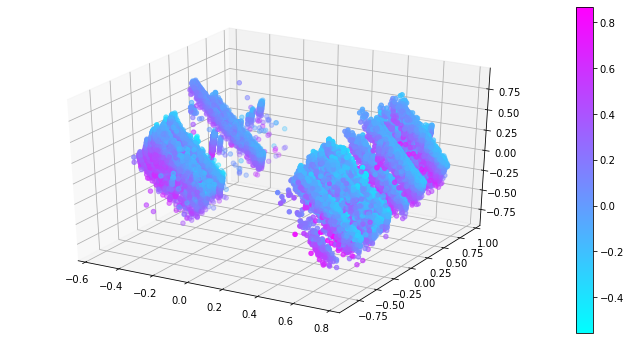

In [128]:
# 4-D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduced[:,0]
y = reduced[:,1]
z = reduced[:,2]
c = reduced[:,3]
c = reduced[:,4]

img = ax.scatter(x, y, z, c=c, cmap=plt.cool())
fig.colorbar(img)
plt.show()

In [129]:
reduced_df = pd.DataFrame(reduced, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])
reduced_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.673080,0.401531,0.486921,-0.284934,0.203749,0.062641
1,0.736811,0.731884,-0.166678,-0.227537,0.115319,0.036930
2,0.570942,0.476286,0.614930,0.378602,0.053110,-0.057842
3,0.731435,0.789403,-0.141452,-0.214078,-0.068550,-0.118990
4,0.689126,0.530186,0.307351,-0.260475,0.069568,0.025571


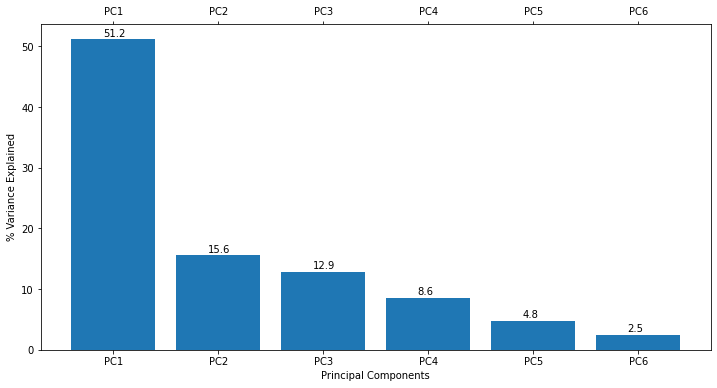

In [172]:
plt.bar(x = reduced_df.columns, height = np.array([0.512,0.156,0.129,0.086,0.048,0.025])*100)
plt.xlabel('Principal Components')
plt.ylabel('% Variance Explained')
    
for i, v in enumerate(np.array([0.512,0.156,0.129,0.086,0.048,0.025])*100):
    plt.text(xlocs[i] - 0.1, v + 0.5, str(v))
    
plt.show()

In [160]:
reduced_df.to_csv('data/2_fs.csv', index = False)
df_t.to_csv('data/2_df_transform.csv', index = False)